In [2]:
import pandas as pd
import numpy as np
from math import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from matplotlib.pyplot import boxplot 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# X_train_full = pd.read_csv('../input/train.csv', index_col='Id')
# X_test = pd.read_csv('../input/test.csv', index_col='Id')
# X_train_full = pd.read_csv('/Users/avyny/Documents/Data_analyses-Kaggle/Data_House_Pricing/train.csv', index_col='Id')
# X_test = pd.read_csv('/Users/avyny/Documents/Data_analyses-Kaggle/Data_House_Pricing/test.csv', index_col='Id')
X_train_full = pd.read_csv('D:\\Learning_IT\\Data_analyses-Kaggle\\Data_House_Pricing\\train.csv', index_col='Id')
X_test = pd.read_csv('D:\\Learning_IT\\Data_analyses-Kaggle\\Data_House_Pricing\\test.csv', index_col='Id')

## Separating target value and features
y = X_train_full.SalePrice              
X_train_full.drop(['SalePrice'], axis=1, inplace=True)

In [4]:
## Detecting of NA
missing_val_count_by_column = (X_train_full.isnull().sum())
missing_val_count_by_column[missing_val_count_by_column > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [5]:
## So, a lot of missing values in column 'Alley' - it is better to delete it
# Also I decided to drop 'Utilities' because it's close to constant variable
X_train_full = X_train_full.drop(['Alley', 'Utilities'], axis = 1)
X_test = X_test.drop(['Alley', 'Utilities'], axis = 1)

In [6]:
# Finding outliers in SalePrice
pd.DataFrame(y).sort_values(by = 'SalePrice', ascending = False).head(4)

,SalePrice
Id,
692,755000
1183,745000
1170,625000
899,611657


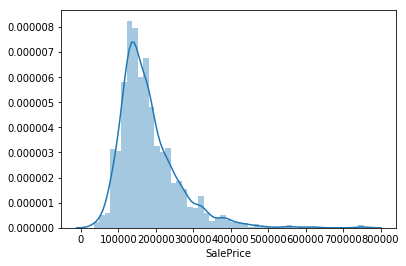

In [7]:
# Density plot for Sale Prices
sns.distplot(y)

In [8]:
### POSSIBLE OUTLIERS

# y = y.drop([692, 1183, 1170, 899], axis = 0)
# X_train_full = X_train_full.drop([692, 1183, 1170, 899], axis = 0)

# The most expensive SalePrice is obsevations # 692, 1183, 1170, 899 (> 600000)

# Huge 'LotArea' in observations # 314, 336, 250, 707 (> 100000 )
# Huge 'LotFrontage' in observations # 1299, 935, 1128 ( > 180 )
# Huge 'GrLivArea'(общая жилая площадь) # 1299, 524, 1183, 692 ( > 4000 )


In [9]:
## Preprocessing data
### Simplifying features
X_train_full['Street'], X_test['Street'] = X_train_full['Street'].map({'Pave': 1, 'Grvl': 0}), X_test['Street'].map({'Pave': 1, 'Grvl': 0})

X_train_full['Condition2'] = X_train_full['Condition2'].apply(lambda z: 1 if z == 'Norm' else 0)
X_test['Condition2'] = X_test['Condition2'].apply(lambda z: 1 if z == 'Norm' else 0)

X_train_full['RoofMatl'] = X_train_full['RoofMatl'].apply(lambda x: 'CompShg' if x == 'CompShg' else 'Tar&Grv' if x == 'Tar&Grv' else 'Others')
X_test['RoofMatl'] = X_test['RoofMatl'].apply(lambda x: 'CompShg' if x == 'CompShg' else 'Tar&Grv' if x == 'Tar&Grv' else 'Others')

X_train_full['Heating'] = X_train_full['Heating'].apply(lambda x: 'GasA' if x == 'GasA' else 'GasW' if x == 'GasW' else 'Others')
X_test['Heating'] = X_test['Heating'].apply(lambda x: 'GasA' if x == 'GasA' else 'GasW' if x == 'GasW' else 'Others')

X_train_full['CentralAir'] = X_train_full['CentralAir'].map({'Y': 1, 'N': 0})
X_test['CentralAir'] = X_test['CentralAir'].map({'Y': 1, 'N': 0})

### Filling NA with variables
X_train_full['LotFrontage'] = X_train_full.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X_test['LotFrontage'] = X_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

X_test['BsmtFinSF1'] = X_test['BsmtFinSF1'].fillna(0)
X_test['BsmtFinSF2'] = X_test['BsmtFinSF2'].fillna(0)
X_test['BsmtUnfSF'] = X_test['BsmtUnfSF'].fillna(0)
X_test['TotalBsmtSF'] = X_test['TotalBsmtSF'].fillna(0)
X_train_full['BsmtQual'], X_test['BsmtQual'] = X_train_full['BsmtQual'].fillna('NoBsmt'), X_test['BsmtQual'].fillna('NoBsmt')
X_train_full['BsmtCond'], X_test['BsmtCond'] = X_train_full['BsmtCond'].fillna('NoBsmt'), X_test['BsmtCond'].fillna('NoBsmt')
X_train_full['BsmtExposure'], X_test['BsmtExposure'] = X_train_full['BsmtExposure'].fillna('NoBsmt'), X_test['BsmtExposure'].fillna('NoBsmt')
X_train_full['BsmtFinType1'], X_test['BsmtFinType1'] = X_train_full['BsmtFinType1'].fillna('NoBsmt'), X_test['BsmtFinType1'].fillna('NoBsmt')
X_train_full['BsmtFinType2'], X_test['BsmtFinType2'] = X_train_full['BsmtFinType2'].fillna('NoBsmt'), X_test['BsmtFinType2'].fillna('NoBsmt')

X_test['BsmtFullBath'] = X_test['BsmtFullBath'].fillna(0)
X_test['BsmtHalfBath'] = X_test['BsmtHalfBath'].fillna(0)
X_train_full['FireplaceQu'] = X_train_full['FireplaceQu'].fillna('NoFireplace')
X_test['FireplaceQu'] = X_test['FireplaceQu'].fillna('NoFireplace')

X_train_full['GarageType'], X_test['GarageType']  = X_train_full['GarageType'].fillna('NoGarage'), X_test['GarageType'].fillna('NoGarage')
X_train_full['GarageYrBlt'], X_test['GarageYrBlt']  = X_train_full['GarageYrBlt'].fillna(0), X_test['GarageYrBlt'].fillna(0)
X_train_full['GarageFinish'], X_test['GarageFinish']  = X_train_full['GarageFinish'].fillna('NoGarage'), X_test['GarageFinish'].fillna('NoGarage')
X_train_full['GarageQual'], X_test['GarageQual']  = X_train_full['GarageQual'].fillna('NoGarage'), X_test['GarageQual'].fillna('NoGarage')
X_train_full['GarageCond'], X_test['GarageCond']  = X_train_full['GarageCond'].fillna('NoGarage'), X_test['GarageCond'].fillna('NoGarage')
X_test['GarageCars'] = X_test['GarageCars'].fillna(0)
X_test['GarageArea'] = X_test['GarageArea'].fillna(0)
X_train_full['MasVnrArea'], X_test['MasVnrArea'] = X_train_full['MasVnrArea'].fillna(0), X_test['MasVnrArea'].fillna(0)

X_train_full['PoolQC'], X_test['PoolQC'] = X_train_full['PoolQC'].fillna('NoPool'), X_test['PoolQC'].fillna('NoPool')
X_train_full['Fence'], X_test['Fence'] = X_train_full['Fence'].fillna('NoFence'), X_test['Fence'].fillna('NoFence')

X_train_full['MiscFeature'], X_test['MiscFeature'] = X_train_full['MiscFeature'].fillna('NoMiscFeature'), X_test['MiscFeature'].fillna('NoMiscFeature')


### Creating additional syntetic variables
X_train_full['Total_amt_bathrooms'] = X_train_full.BsmtFullBath + X_train_full.FullBath + 0.5*X_train_full.BsmtHalfBath + 0.5*X_train_full.HalfBath
X_test['Total_amt_bathrooms'] = X_test.BsmtFullBath + X_test.FullBath + 0.5*X_test.BsmtHalfBath + 0.5*X_test.HalfBath

X_train_full['Total_porch_sf'] = X_train_full.OpenPorchSF + X_train_full.EnclosedPorch + X_train_full['3SsnPorch'] + X_train_full.ScreenPorch
X_test['Total_porch_sf'] = X_test.OpenPorchSF + X_test.EnclosedPorch + X_test['3SsnPorch'] + X_test.ScreenPorch

X_train_full['Remodel_aft_building_years'] = X_train_full.YearRemodAdd - X_train_full.YearBuilt
X_test['Remodel_aft_building_years'] = X_test.YearRemodAdd - X_test.YearBuilt

X_train_full['Total_SF'] = X_train_full.TotalBsmtSF + X_train_full['1stFlrSF'] + X_train_full['2ndFlrSF']
X_test['Total_SF'] = X_test.TotalBsmtSF + X_test['1stFlrSF'] + X_test['2ndFlrSF']

X_train_full['Has2ndFloor'] = X_train_full['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
X_test['Has2ndFloor'] = X_test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasFireplace'] = X_train_full['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasFireplace'] = X_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasBsmt'] = X_train_full['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasBsmt'] = X_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasGarage'] = X_train_full['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasGarage'] = X_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasPorch'] = X_train_full['Total_porch_sf'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasPorch'] = X_test['Total_porch_sf'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasPool'] = X_train_full['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
X_test['HasPool'] = X_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

X_train_full['HasFence'] = X_train_full['Fence'].apply(lambda x: 1 if x != 'NoFence' else 0)
X_test['HasFence'] = X_test['Fence'].apply(lambda x: 1 if x != 'NoFence' else 0)


### Changin dtypes of some columns
X_train_full['GarageYrBlt'], X_test['GarageYrBlt'] = X_train_full['GarageYrBlt'].astype('int64'), X_test['GarageYrBlt'].astype('int64')

X_train_full = X_train_full.drop('YearRemodAdd', axis=1)
X_test = X_test.drop('YearRemodAdd', axis=1)

In [10]:
## Imputing missing variables with simple imputer for least vars

X_train_full = pd.get_dummies(X_train_full)
X_test = pd.get_dummies(X_test)

si = SimpleImputer(strategy='most_frequent')

X_train_a = pd.DataFrame(si.fit_transform(X_train_full))
X_train_a.columns = X_train_full.columns

X_test_a = pd.DataFrame(si.fit_transform(X_test))
X_test_a.columns = X_test.columns
X_test_a.index = X_test.index

X_train_a, X_test_a = X_train_a.align(X_test_a, join='left', axis=1)

In [11]:
## Deleting possible outliers

# The most expensive SalePrice is obsevations # 692, 1183, 1170, 899 (> 600000)

# Huge 'LotArea' in observations # 314, 336, 250, 707 (> 100000 )
# Huge 'LotFrontage' in observations # 1299, 935, 1128 ( > 180 )
# Huge 'GrLivArea'(общая жилая площадь) # 1299, 524, 1183, 692 ( > 4000 )

y = y.drop([1183, 692, 1299, 524], axis = 0)
X_train_a = X_train_a.drop([1183, 692, 1299, 524], axis = 0)

In [12]:
## Splitting variables on train//test sizes
X_train, X_valid, y_train, y_valid = train_test_split(X_train_a, y, train_size = 0.8, test_size = 0.2, random_state = 25)

In [13]:
y_train = np.log1p(y_train)

In [18]:
model = XGBRegressor()
parameters = {'n_estimators': [300, 500, 700, 800, 900],
              'learning_rate': [.02, .03, .04, .05, .08, .1],
              'max_depth': [3, 4, 5, 6, 7],
              'subsample': [.5, .7, .8, 1],
              'colsample_bytree': [.8, 1]}
cv = GridSearchCV(model, param_grid=parameters, scoring = 'neg_mean_squared_error')
cv.fit(X_train, y_train)

[23:49:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:49:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:49:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:49:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:49:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:17] WARNI

[00:05:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:52] WARNI

[00:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:28:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:28:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:29:03] WARNI

[00:47:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:31] WARNI

[01:11:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:11:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:12:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:12:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:13:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:13:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:14:19] WARNI

[01:40:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:32] WARNI

[02:12:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:13:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:50] WARNI

[02:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:34:15] WARNI

[02:51:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:51:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:52:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:52:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:53:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:53:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:54:02] WARNI

[03:13:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:14:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:14:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:03] WARNI

[03:40:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:40:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:41:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:41:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:42:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:43:47] WARNI

[04:11:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:11:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:11:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:12:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:12:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:13:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:13:28] WARNI

[04:49:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:50:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:50:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:50:19] WARNI

[05:05:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:06:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:06:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:08:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:08:41] WARNI

[05:25:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:39] WARNI

[05:47:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:32] WARNI

[06:13:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:29] WARNI

[06:45:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:47:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:47:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:48:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:48:31] WARNI

KeyboardInterrupt: 

In [ ]:
cv.best_estimator_ 
cv.best_score_ 
cv.best_params_ 

In [15]:
# predictions = model.predict(X_valid)
# predictions = np.floor(np.expm1(predictions))

# mae = mean_absolute_error(y_valid, predictions)
# print("Mean Absolute Error:" , mae)

# y_valid = np.array(y_valid)
# # base = 2.5611
# # # base = 2.494
# # rmse = np.sqrt(mean_squared_error((np.log(predictions_2)/np.log(base)), (np.log(y_valid)/np.log(base))))
# # rmse = np.sqrt(mean_squared_error(predictions_2, y_valid))
# rmse = np.sqrt(mean_squared_error(np.log(predictions), np.log(y_valid)))
# print("Root Mean Squared Error:" , rmse)

# rmse2 = np.sqrt(mean_squared_error(predictions, y_valid))
# print("Root Mean Squared Error:" , rmse2)

In [16]:
## model n_estimators = 450, learning_rate= 0.065, colsample_bytree = 0.8, subsample = 0.8, max_depth = 4, reg_lambda = 0.998
## random_state = 25
## 0.8/0.2 train/test sizes

## with deleting outlier 1183 
#Mean Absolute Error: 14862.07  Root Mean Squared Error: 0.12970 Root Mean Squared Error: 26221.97
# SCORE1 = 14331.939; SCORE2 =  0.13395
# (LOG 'y' target variable)
#Mean Absolute Error: 14397.342  Root Mean Squared Error: 0.1274  Root Mean Squared Error: 26656.391
# SCORE1 = 14903.59; SCORE2 = 0.13545 

## outliers # 1183, 692, 1299 
# (LOG 'y' target variable)
# Mean Absolute Error: 12706.3   Root Mean Squared Error: 0.116956  Root Mean Squared Error: 19447.849
# SCORE1 = 14185.03429; SCORE2 = 0.12704  (SCORE2 = 0.13230 (without logariphm))

##outliers # 1183, 692, 1299, 524
# Mean Absolute Error: 12503.683   Root Mean Squared Error: 0.11214  Root Mean Squared Error: 18252.242
# SCORE2 = 0.12688 (without logariphm)
# (LOG 'y' target variable)
# Mean Absolute Error: 12570.852   Root Mean Squared Error: 0.1099  Root Mean Squared Error: 18159.009
#SCORE2 = 0.13386


In [17]:
# preds_test = model.predict(X_test_a)
# # preds_test = np.floor(np.expm1(preds_test))
# output = pd.DataFrame({'Id': X_test_a.index,
#                        'SalePrice': preds_test})
# output.to_csv('submissionEndNastya.csv', index=False)